# Audio Analysis

In [1]:
# link backend
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append('/home/darkangel/ai-light-show/backend')
from backend.config import SONGS_TEMP_DIR, SONGS_DIR

# sample song 
song_name = 'born_slippy'
songs_folder = "/home/darkangel/ai-light-show/songs/"
song_file = f"{songs_folder}{song_name}.mp3"
print(f"song: {song_name} | {song_file}")

# load metadata
from backend.models.song_metadata import SongMetadata
song = SongMetadata(song_name=song_name, songs_folder=songs_folder)
print(f"song metadata: {song}")


song: born_slippy | /home/darkangel/ai-light-show/songs/born_slippy.mp3
song metadata: SongMetadata(song_name=born_slippy, title=born slippy, genre=unknown, bpm=139.99, duration=135.7786865234375, beats=325, arrangement=10)


## Extract Stems

In [2]:
from backend.ai.demucs_split import extract_stems
stems_folder = extract_stems(song_file)

drums_path = f"{stems_folder['output_folder']}/drums.wav"

🎵 Extracting stems from the song...


Noise gate?

In [4]:
from backend.ai.audio_proccess import noise_gate
noise_gate(input_path=drums_path, threshold_db=-35.0)

  Noise gate | min -35.0 dB to /home/darkangel/ai-light-show/songs/temp/htdemucs/born_slippy/drums.wav...


'/home/darkangel/ai-light-show/songs/temp/htdemucs/born_slippy/drums.wav'

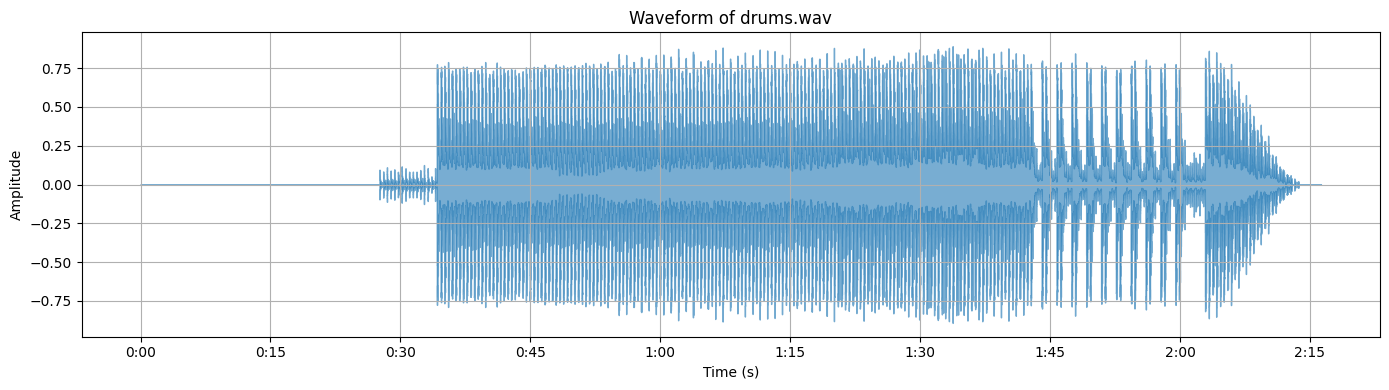

In [5]:
!pip install matplotlib --quiet
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# 🔍 Plot waveform
plt.figure(figsize=(14, 4))
y, sr = librosa.load(drums_path, sr=16000, mono=True)
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform of drums.wav")
plt.xlabel("Time (s)")

num_points = len(y)
times = np.linspace(0, num_points / sr, num_points)
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

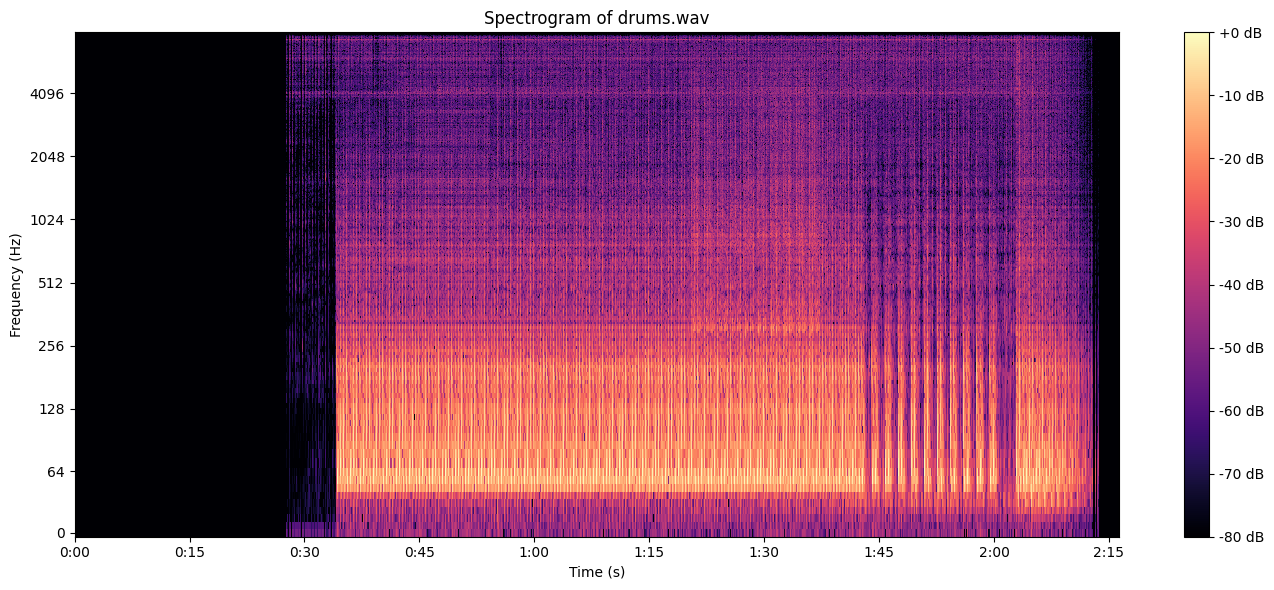

In [8]:
import matplotlib.pyplot as plt
import librosa.display

# Plot spectrogram
S = librosa.stft(y, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of drums.wav')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Pattern Finder

In [6]:
from backend.ai.pattern_finder import get_stem_clusters
found_clusters = get_stem_clusters(song.get_beats_array(), drums_path)

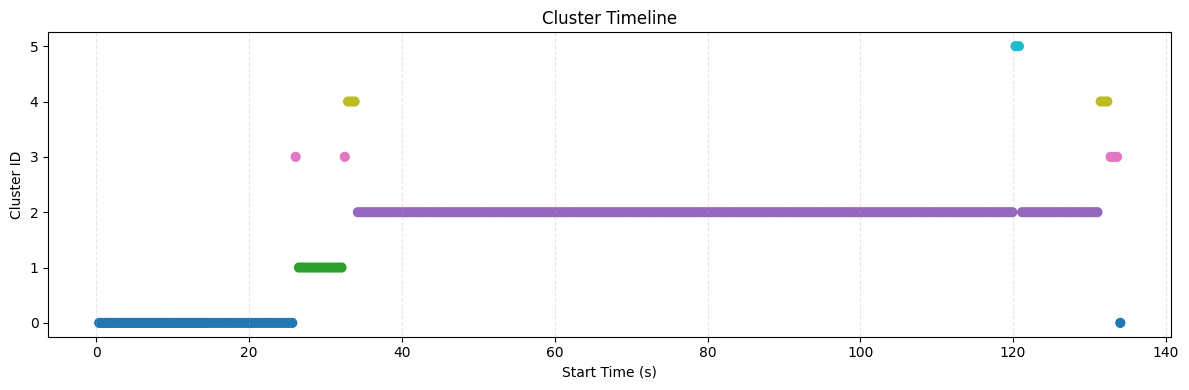

In [7]:
import matplotlib.pyplot as plt

# Extract start times and cluster ids
starts = [item['start'] for item in found_clusters['clusters_timeline']]
clusters = [item['cluster'] for item in found_clusters['clusters_timeline']]

plt.figure(figsize=(12, 4))
plt.scatter(starts, clusters, c=clusters, cmap='tab10', s=40)
plt.xlabel("Start Time (s)")
plt.ylabel("Cluster ID")
plt.title("Cluster Timeline")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()